In [169]:
pip install openpyxl

  Using cached openpyxl-3.0.7-py2.py3-none-any.whl (243 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
Note: you may need to restart the kernel to use updated packages.


In [209]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone
from psaw import PushshiftAPI
import matplotlib.pyplot as plt

In [2]:
# Initialize API
api = PushshiftAPI()

# Data structure

## Submissions

In [ ]:
# # Details on what this query actually does below.
# # Here using it to figure out what some of the fields are.

# start_time = int(datetime(2021, 6, 7).timestamp())
# end_time = int(datetime(2021, 6, 14).timestamp())

# api_request_generator = api.search_submissions(q='(jobs | employment)',
#                                               after = start_time,
#                                               before = end_time)

# sub_recent = pd.DataFrame([submission.d_ for submission in api_request_generator])
# sub_recent.shape

In [40]:
for f in sub_recent.columns:
    print(f)

all_awardings
allow_live_comments
author
author_flair_css_class
author_flair_richtext
author_flair_text
author_flair_type
author_fullname
author_patreon_flair
author_premium
awarders
can_mod_post
contest_mode
created_utc
domain
full_link
gildings
id
is_created_from_ads_ui
is_crosspostable
is_meta
is_original_content
is_reddit_media_domain
is_robot_indexable
is_self
is_video
link_flair_background_color
link_flair_css_class
link_flair_richtext
link_flair_template_id
link_flair_text
link_flair_text_color
link_flair_type
locked
media_only
no_follow
num_comments
num_crossposts
over_18
parent_whitelist_status
permalink
pinned
pwls
retrieved_on
score
selftext
send_replies
spoiler
stickied
subreddit
subreddit_id
subreddit_subscribers
subreddit_type
thumbnail
title
total_awards_received
treatment_tags
upvote_ratio
url
whitelist_status
wls
created
removed_by_category
suggested_sort
post_hint
preview
edited
url_overridden_by_dest
author_flair_background_color
author_flair_template_id
author_flair

Keeping:


* created_utc
* id
* num_comments
* num_crossposts
* retrieved_on
* score
* selftext
* subreddit
* subreddit_id
* title

Not quite sure what these are and whether we should filter (the search) on these:
is_created_from_ads_ui
is_crosspostable
is_meta
is_original_content
is_reddit_media_domain
is_robot_indexable
is_self
is_video
media_only
over_18

subreddit_subscribers
subreddit_type
upvote_ratio
created

domain
full_link vs permalink vs url

In [73]:
sub_recent['subreddit_subscribers']

0         124847
1        2532943
2         248844
3        1718599
4        3080701
          ...   
16400          0
16401      78373
16402          0
16403          0
16404          0
Name: subreddit_subscribers, Length: 16405, dtype: int64

## Getting the dates right

In [ ]:
surveyPeriods = pd.read_excel('/Volumes/Survey_Social_Media_Compare/Methods/Scripts/Surveys/table_details/surveyPeriods.xlsx', sheet_name='AI+HPS')

**The actual query needs to be made with a utc timestamp**

In [307]:
def to_utc_timestamp(date_ts):
    '''

    Parameters:
        date_ts (Timestamp): 

    Returns:
        date (datetime): A datetime object  
    '''

    dateDT = date_ts.replace(tzinfo = timezone.utc).timestamp()
    
    return dateDT


def weekFromDay(day):
    '''
    Work the week starting and ending dates given any date.
    Params:
        day (datetime): Can be a Timestamp (pandas/numpy object) or a datetime.datetime object.

    Returns: 
        weekStart (Timestamp): The date corresponding to the start (i.e. Monday) of the date specified by *day* param.
        weekEnd (Timestamp): The date corresponding to the end (i.e. Sunday) of the date specified by *day* param.
    '''

    weekStart = day - timedelta(days=day.weekday())
    weekEnd = weekStart + timedelta(days=6)

    return weekStart.strftime('%Y-%m-%d'), weekEnd.strftime('%Y-%m-%d')


def nextMonday(date):
#     date = toDatetime(date)

    date_dt = datetime.strptime(date, "%Y-%m-%d")

    nextM = date_dt + timedelta(days=-date_dt.weekday(), weeks=1)

    return nextM

def surveyDates(surveyPeriods):


    # Load survey periods
#     surveyPeriods = pd.read_excel('/Volumes/Survey_Social_Media_Compare/Methods/Scripts/Surveys/table_details/surveyPeriods.xlsx', sheet_name='AI+HPS')

    # Generate tuple of week start and end dates based on the collection dates in the Axios/Ipsos survey. 
    AI_weeks = [weekFromDay(date) for date in surveyPeriods['A_I_start_date']]


    # Get first monday and last sunday from the A/I data collection periods
    firstDate,_ = weekFromDay(surveyPeriods['A_I_start_date'][0])
    _, lastDate = weekFromDay(surveyPeriods['A_I_start_date'].iloc[-1])

    # Create data ranges for all mondays/sundays starting with the first one covered in A/I.
    mondays = pd.date_range(firstDate, lastDate, freq='W-MON')
    leading_mondays = pd.date_range(nextMonday(firstDate), nextMonday(lastDate), freq='W-MON')

    # Get strings
    mondays_str = mondays.strftime('%Y-%m-%d')
    leading_mondays_str = leading_mondays.strftime('%Y-%m-%d')

    # Saving all the results in a tuple
    all_weeks_utc = [(to_utc_timestamp(m), to_utc_timestamp(s)) for m, s in zip(mondays, leading_mondays)]
    all_weeks_str = [(m, s) for m, s in zip(mondays_str, leading_mondays_str)]
    
    return all_weeks_utc, all_weeks_str

In [308]:
all_weeks_utc, all_weeks_str = surveyDates(surveyPeriods)

In [309]:
all_weeks_utc

[(1603065600.0, 1603670400.0),
 (1603670400.0, 1604275200.0),
 (1604275200.0, 1604880000.0),
 (1604880000.0, 1605484800.0),
 (1605484800.0, 1606089600.0),
 (1606089600.0, 1606694400.0),
 (1606694400.0, 1607299200.0),
 (1607299200.0, 1607904000.0),
 (1607904000.0, 1608508800.0),
 (1608508800.0, 1609113600.0),
 (1609113600.0, 1609718400.0),
 (1609718400.0, 1610323200.0),
 (1610323200.0, 1610928000.0),
 (1610928000.0, 1611532800.0),
 (1611532800.0, 1612137600.0),
 (1612137600.0, 1612742400.0),
 (1612742400.0, 1613347200.0),
 (1613347200.0, 1613952000.0),
 (1613952000.0, 1614556800.0),
 (1614556800.0, 1615161600.0),
 (1615161600.0, 1615766400.0),
 (1615766400.0, 1616371200.0),
 (1616371200.0, 1616976000.0),
 (1616976000.0, 1617580800.0),
 (1617580800.0, 1618185600.0),
 (1618185600.0, 1618790400.0),
 (1618790400.0, 1619395200.0),
 (1619395200.0, 1620000000.0),
 (1620000000.0, 1620604800.0),
 (1620604800.0, 1621209600.0),
 (1621209600.0, 1621814400.0)]

In [311]:
datetime.utcfromtimestamp(all_weeks_utc[0])

TypeError: an integer is required (got type tuple)

In [280]:
AI_weeks = [weekFromDay(date) for date in surveyPeriods['A_I_start_date']]

# Get first monday and last sunday from the A/I data collection periods
firstDate,_ = weekFromDay(surveyPeriods['A_I_start_date'][0])
_, lastDate = weekFromDay(surveyPeriods['A_I_start_date'].iloc[-1])

In [283]:
mondays = pd.date_range(firstDate, lastDate, freq='W-MON')
leading_mondays = pd.date_range(nextMonday(firstDate), nextMonday(lastDate), freq='W-MON')

In [284]:
leading_mondays

DatetimeIndex(['2020-10-26', '2020-11-02', '2020-11-09', '2020-11-16',
               '2020-11-23', '2020-11-30', '2020-12-07', '2020-12-14',
               '2020-12-21', '2020-12-28', '2021-01-04', '2021-01-11',
               '2021-01-18', '2021-01-25', '2021-02-01', '2021-02-08',
               '2021-02-15', '2021-02-22', '2021-03-01', '2021-03-08',
               '2021-03-15', '2021-03-22', '2021-03-29', '2021-04-05',
               '2021-04-12', '2021-04-19', '2021-04-26', '2021-05-03',
               '2021-05-10', '2021-05-17', '2021-05-24'],
              dtype='datetime64[ns]', freq='W-MON')

In [288]:
to_utc_timestamp(mondays[0])

1603065600.0

In [292]:
print(datetime.utcfromtimestamp(to_utc_timestamp(leading_mondays[0])))

2020-10-26 00:00:00


In [253]:
a, b = weekFromDay(surveyPeriods['A_I_start_date'][0])

In [256]:
print(datetime.utcfromtimestamp(a))
print(datetime.utcfromtimestamp(b))

2020-10-19 00:00:00
2020-10-25 00:00:00


In [247]:
a.replace(tzinfo = timezone.utc).timestamp()

1603065600.0

In [231]:
start, end = weekFromDay(surveyPeriods['A_I_start_date'][0])
bla = toDatetime(bla)
bla = bla.replace(tzinfo = timezone.utc).timestamp()
print(datetime.utcfromtimestamp(bla))

TypeError: strptime() argument 1 must be str, not tuple

datetime.datetime(2020, 10, 19, 0, 0)

In [196]:
print(datetime.utcfromtimestamp(bla))

2021-06-06 22:59:59


In [ ]:
start_date = datetime(2021, 6, 6)

In [206]:
start_date = toDatetime('2021-')


In [215]:
bla = start_date.replace(tzinfo = timezone.utc).timestamp()

TypeError: unsupported operand type(s) for -: 'datetime.datetime' and 'NoneType'

In [216]:

print(datetime.utcfromtimestamp(bla))

2021-06-06 23:59:59


In [152]:
start_date

datetime.datetime(2021, 6, 6, 23, 59, 59)

In [123]:
print(sub_recent['created'][0])
print(datetime.utcfromtimestamp(float(sub_recent['created'][0])))


print(sub_recent['created_utc'][0])
print(datetime.utcfromtimestamp(float(sub_recent['created_utc'][0])))




1623621576.0
2021-06-13 21:59:36
1623625176
2021-06-13 22:59:36


In [76]:
sub_recent['subreddit_type'].value_counts()

public        14657
user           1151
restricted      597
Name: subreddit_type, dtype: int64

In [86]:
len(np.unique(sub_recent['subreddit']))
# sub_recent['subreddit'].value_counts()

4657

In [87]:
len(np.unique(sub_recent['subreddit_subscribers']))

12783

In [95]:
# sub_recent['date'] = pd.to_datetime(sub_recent['created_utc'], utc=True, unit='s')
print(min(sub_recent['date']))
print(max(sub_recent['date']))

2021-06-06 23:00:10+00:00
2021-06-13 22:59:36+00:00


In [70]:
def fields_dist(submissions_data):
    '''
    is_created_from_ads_ui
    is_crosspostable
    is_meta
    is_original_content
    is_reddit_media_domain
    is_robot_indexable
    is_self
    is_video
    media_only
    over_18
    '''
    
    fields_dict = dict()
    
    l = len(submissions_data)
    
    fields_dict['is_ads'] = np.sum(submissions_data['is_created_from_ads_ui'])/l
    fields_dict['is_crosspostable'] = np.sum(submissions_data['is_crosspostable'])/l
    fields_dict['is_meta'] = np.sum(submissions_data['is_meta'])/l
    fields_dict['is_original_content'] = np.sum(submissions_data['is_original_content'])/l
    fields_dict['is_reddit_media_domain'] = np.sum(submissions_data['is_reddit_media_domain'])/l
    fields_dict['is_robot_indexable'] = np.sum(submissions_data['is_robot_indexable'])/l
    fields_dict['is_self'] = np.sum(submissions_data['is_self'])/l
    fields_dict['is_video'] = np.sum(submissions_data['is_video'])/l
    fields_dict['media_only'] = np.sum(submissions_data['media_only'])/l
    fields_dict['over_18'] = np.sum(submissions_data['over_18'])/l
    
    for k,v in fields_dict.items():
        print(k,":",round(v,3))
    
    
    
#     print(f"{round(fields_dict['ads'],3)}% created from ads")
#     print(f"{round(fields_dict['crosspostable'],3)}% are crosspostable")
#     print(f"{round(fields_dict['meta'],3)}% are meta")
#     print(f"{round(fields_dict['original'],3)}% are OC")
#     print(f"{round(fields_dict['media_domain'],3)}% are media_domain")
#     print(f"{round(fields_dict['r_indexable'],3)}% are robot indexable")
#     print(f"{round(fields_dict['self'],3)}% are self")
#     print(f"{round(fields_dict['video'],3)}% are video")
    
    
    
#     '''{}\% of posts are created from ads\n
#     {}/% of posts are crosspostable\n
#     {}/% of posts are meta'''.\
#           format(round(p_ads,3), 
#                  round(p_crosspostable,3),
#                  round(p_meta, 3))
        
    

In [71]:
is_fields_dist(sub_recent)

is_ads : 0.003
is_crosspostable : 0.936
is_meta : 0.0
is_original_content : 0.004
is_reddit_media_domain : 0.027
is_robot_indexable : 0.944
is_self : 0.872
is_video : 0.003


In [65]:
for k,v in bla.items():
    print(k,v)

ads 0.0032307223407497714
crosspostable 0.935568424260896
meta 0.0
original 0.00365742151782993
media_domain 0.027003962206644316
r_indexable 0.943980493751905
self 0.8715635476988723
video 0.0028649801889667785


# Getting all submissions with more than a certain upvote score

In [5]:
# Initialize API
api = PushshiftAPI()

# Set up generator to make API request.
api_request_generator = api.search_submissions(subreddit='news', score = ">2000")

# Make the request and collect results into a pd.DataFrame
news_submissions = pd.DataFrame([submission.d_ for submission in api_request_generator])

# Shape (n_results, n_features)
news_submissions.shape

In [19]:
# Available features
news_submissions.columns

Index(['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_patreon_flair',
       'author_premium', 'awarders', 'can_mod_post', 'contest_mode',
       'created_utc', 'domain', 'edited', 'full_link', 'gilded', 'gildings',
       'id', 'is_crosspostable', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_richtext',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media_only',
       'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'pwls',
       'retrieved_on', 'score', 'selftext', 'send_replies', 'spoiler',
       'stickied', 'subreddit', 'subreddit_id', 'subreddit_subscribers',
       'subreddit_type', 'thumbnail', 'title', 'total_awards_received',
       'treatment_ta

In [17]:
# Transform to datetime
news_submissions['date'] = pd.to_datetime(jokes_submissions['created_utc'], utc = True, unit = 's')
news_submissions[['date','title', 'score', 'num_comments', 'selftext']].sample(20)

,date,title,score,num_comments,selftext
747,2019-07-24 03:28:46+00:00,"My best friend called me and said ""An evil wiz...",12514,117,I drove all the way to his house just to find ...
822,2019-07-10 09:43:25+00:00,I went to the liquor store on my bicycle and b...,6395,93,\n\n...'cause I fell 7 times on the way home...
161,2020-04-15 14:42:22+00:00,Husband doing crossword with his wife,2528,132,"\n\nHusband: Emphatic no, five letters.\n\nWi..."
1312,2019-04-18 20:13:24+00:00,The girl with no arms and legs laying by the pool,9047,238,There’s a girl with no arms and legs laying by...
5600,2016-12-21 09:12:29+00:00,Break ups are the worst in China...,3047,180,You see her face everywhere.
2864,2018-04-05 16:00:16+00:00,I asked my girlfriend to describe me in 5 words.,34538,537,"She said I'm mature, I'm moral, I'm pure, I'm ..."
5254,2017-02-18 22:10:34+00:00,Two blind pilots enter a plane,4247,100,They have sunglasses and white sticks. As the ...
2569,2018-05-19 15:06:42+00:00,Don't ever underestimate a Scottish police off...,5240,144,A London lawyer runs a stop sign and gets pull...
3232,2018-02-12 05:04:36+00:00,Afternoon Sex,36740,663,"The only way to pull off a Sunday afternoon ""q..."
711,2019-07-30 11:44:48+00:00,I once dated a girl who had a twin.,22951,356,People kept asking me how I could tell them ap...


# Getting submission based on search keyword

Searching comments is done in the same way, but using api.search_comments instead of api.search_submissions

In [28]:
# Set up generator to make API request.
api_request_generator = api.search_submissions(q='(jobs | employment)', score = '>2000')

q_jobs_submissions = pd.DataFrame([submission.d_ for submission in api_request_generator])

q_jobs_submissions['date'] = pd.to_datetime(q_jobs_submissions['created_utc'], utc=True, unit='s')

q_jobs_submissions.shape

(4645, 102)

In [29]:
q_jobs_submissions[['date','title', 'score', 'num_comments', 'selftext']].sample(20)

,date,title,score,num_comments,selftext
115,2020-07-21 18:38:33+00:00,Aita for calling out my sister after she shame...,12490,1036,I’m 28 my sister is 26. She got married three ...
2041,2018-03-05 16:21:16+00:00,TIL Before he was a famous musician Johnny Cas...,32066,499,
3571,2016-10-09 18:06:11+00:00,My boyfriend and I started a business out of h...,3612,2867,Hi Reddit! I’m Monique. Two years ago I was wo...
3687,2016-07-24 12:55:42+00:00,EMSK the most popular resumes are either chron...,2039,54,[deleted]
3202,2017-01-26 12:45:34+00:00,Keystone pipeline will create just 35 permanen...,31452,3040,
577,2019-08-15 07:08:55+00:00,Video Game Developer Insight on EA's Relations...,2581,460,I've been a video game developer for near thre...
1973,2018-03-23 15:14:04+00:00,I work as a companion to a man who has Down sy...,3045,251,His Individual Support Plan allows for no alon...
687,2019-07-19 10:47:41+00:00,Fine! But you're stealing their jobs!,3068,163,I love Target. I'm also a stress eater who hap...
3446,2016-11-30 00:42:18+00:00,You are only a Temp!,3459,253,So in my time out of tech support from the lig...
3683,2016-07-26 04:35:07+00:00,Ken M On Six-Figure Jobs,3944,163,


In [30]:
max(q_jobs_submissions['date'])

Timestamp('2021-06-14 02:29:15+0000', tz='UTC')

In [ ]:
# Collect submissions/comments within a certain period

In [3]:
start_time = int(datetime(2020, 10, 23).timestamp())
end_time = int(datetime(2020, 10, 26).timestamp())

api_request_generator = api.search_submissions(q='(jobs | employment)',
                                              after = start_time,
                                              before = end_time)

q_jobs_submissions = pd.DataFrame([submission.d_ for submission in api_request_generator])
q_jobs_submissions.shape

(6205, 99)

In [5]:
start_time = int(datetime(2020, 10, 23).timestamp())
end_time = int(datetime(2020, 10, 26).timestamp())

api_request_generator2 = api.search_submissions(q='(jobs OR employment)',
                                              after = start_time,
                                              before = end_time)

q_jobs_submissions2 = pd.DataFrame([submission.d_ for submission in api_request_generator2])
q_jobs_submissions2.shape

(65, 71)

In [11]:
q_jobs_submissions['date'] = pd.to_datetime(q_jobs_submissions['created_utc'], utc=True, unit='s')
q_jobs_submissions[['date','title', 'score', 'num_comments', 'selftext']].sample(20)

,date,title,score,num_comments,selftext
1630,2020-10-25 03:22:31+00:00,I’m addicted to caffeine pills,1,16,I probably take 1000mg-1400mg is caffeine a da...
4054,2020-10-23 21:50:56+00:00,Question about gaps after a foundation program...,1,4,"Hello, I wanna ask about a gap in trade.\n\nI'..."
5805,2020-10-23 03:14:45+00:00,HOW THIS WORKS...,1,0,\n* Website of the course: https://LinuxUpskil...
5259,2020-10-23 10:29:21+00:00,Revamp your problems by the help of real black...,1,0,&amp;#x200B;\n\n[ ](https://preview.redd.it/t...
5724,2020-10-23 03:54:07+00:00,Scrapping together a network,1,5,So I got a bunch of gear that our shop has acc...
2594,2020-10-24 16:20:41+00:00,Our new home. ♥️ It’s about 400 years old. We ...,1,34,
1979,2020-10-24 22:44:32+00:00,Can you get the full maternity EI amount over ...,1,8,Let's say maternity EI pays you 500 a week for...
1034,2020-10-25 12:58:31+00:00,"Amateur &amp; POV doggy, anal, blow jobs, cum ...",1,2,
5072,2020-10-23 12:37:24+00:00,What exactly does the 'Check Access' button in...,1,3,Hello all\n\nWe are having trouble with device...
3810,2020-10-24 00:26:20+00:00,The job market seriously stinks,1,8,I enlisted in the Air Force at the start of th...


In [ ]:
q_jobs_submissions['selftext', 'subreddit'][5805]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



ERROR! Session/line number was not unique in database. History logging moved to new session 611
Traceback (most recent call last):
  File "/Users/munchausend/opt/anaconda3/envs/redditScrapper/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 3080, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 4554, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 4562, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: ('selftext', 'subreddit')

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/munchausend/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.u

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/munchausend/opt/anaconda3/envs/redditScrapper/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 3080, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 4554, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 4562, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: ('selftext', 'subreddit')

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/munchausend/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-026950f2ef79>", line 1, in <module>
    q

In [7]:
q_jobs_submissions2['date'] = pd.to_datetime(q_jobs_submissions2['created_utc'], utc=True, unit='s')
q_jobs_submissions2[['date','title', 'score', 'num_comments', 'selftext']].sample(20)

,date,title,score,num_comments,selftext
27,2020-10-24 18:22:02+00:00,Do I have to list ALL past employment on appli...,1,12,I am 29 and applying for law school for the fi...
21,2020-10-25 01:52:09+00:00,Why are so many people relying on a stimulus?,1,202,This is not meant to be demeaning or insulting...
45,2020-10-23 19:46:58+00:00,I never thought I could hate someone so much.,1,2,My belief that being friends with an ex is ver...
41,2020-10-23 23:36:18+00:00,35 [M4F] I want to turn you into white trash,1,0,"Have you ever wanted to just ""let go""? To sto..."
16,2020-10-25 08:08:50+00:00,I'm a public policy analyst that has dedicated...,1,9,"Hey peeps,\n\nMy name is Tudor! By trade, I a..."
4,2020-10-25 20:25:33+00:00,"Was super excited about finally getting a job,...",1,0,I don’t even know how to start with this. Apol...
10,2020-10-25 15:59:03+00:00,Hi there. I'm thinking of applying to the Robe...,1,3,Hi there. I'm thinking of applying to the Robe...
43,2020-10-23 21:55:57+00:00,"Moving to Winnipeg from Edmonton, what is the ...",1,21,I currently work for the Government of Alberta...
44,2020-10-23 20:18:48+00:00,prop 22,1,13,Disclaimer: I'm sorry if this does not belong ...
48,2020-10-23 16:45:32+00:00,[HIRING] Research Data Analyst at University o...,1,0,"University of California, Riverside is looking..."


In [13]:
q_jobs_submissions2['selftext'][45]

'My belief that being friends with an ex is very rare, and even in those rarities there are many attempting to be friends and haven’t quite realized the ship they’re trying to salvage is already sunk. \n\nI happen to be in one of these situations. At this point the only options is ghosting, as bad as it sounds, it is the only healthy choice. I’m not the greatest person in the world I may even share some of the Narc traits my ex has, it could be one of the biggest reasons I feel I hate her. But it’s not the only reason by a long shot.\n\nShe’s reached out and I have reached out when I know I shouldn’t have. Anytime we connect now it’s usually me who starts an argument because shes doing and saying the same things that added to our inviability. She starts complaining about someone making her feel a certain way, there’s something for her to complain about constantly, and she still talks about her ex, comparing me to him, and I’m sitting there like wait wtf I don’t have to listen to any of

In [48]:
start_time = int(datetime(2020, 10, 23).timestamp())
end_time = int(datetime(2020, 10, 26).timestamp())

api_request_generator = api.search_comments(q='(jobs | employment)',
                                              after = start_time,
                                              before = end_time)

q_jobs_comments = pd.DataFrame([submission.d_ for submission in api_request_generator])
q_jobs_comments['date'] = pd.to_datetime(q_jobs_comments['created_utc'], utc=True, unit='s')
q_jobs_comments.shape

(35706, 39)

In [51]:
q_jobs_comments.columns

Index(['all_awardings', 'associated_award', 'author',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_template_id',
       'author_flair_text', 'author_flair_text_color', 'author_flair_type',
       'author_fullname', 'author_patreon_flair', 'author_premium', 'awarders',
       'body', 'collapsed_because_crowd_control', 'comment_type',
       'created_utc', 'gildings', 'id', 'is_submitter', 'link_id', 'locked',
       'no_follow', 'parent_id', 'permalink', 'retrieved_on', 'score',
       'send_replies', 'stickied', 'subreddit', 'subreddit_id',
       'top_awarded_type', 'total_awards_received', 'treatment_tags',
       'created', 'distinguished', 'edited', 'author_cakeday', 'date'],
      dtype='object')

In [ ]:
q_jobs_comments[['date', 'score', 'body', 'parent_id']].sample(20)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



ERROR! Session/line number was not unique in database. History logging moved to new session 612
Traceback (most recent call last):
  File "/Users/munchausend/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-cd530e1fd048>", line 1, in <module>
    q_jobs_comments[['date', 'score', 'body', 'parent_id']].sample(20)
NameError: name 'q_jobs_comments' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/munchausend/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/munchausend/.local/lib/python3.7/site-packages/IPytho

## Filtering

In [42]:
api_request_generator = api.search_submissions(q='(jobs | employment)',
                                              after = start_time,
                                              before = end_time, 
                                              filter=['url','author', 'title', 'subreddit'],
                                              limit = 10000)

q_jobs_submissions = pd.DataFrame([submission.d_ for submission in api_request_generator])
q_jobs_submissions.shape

/Users/munchausend/opt/anaconda3/envs/redditScrapper/lib/python3.7/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
/Users/munchausend/opt/anaconda3/envs/redditScrapper/lib/python3.7/site-packages/psaw/PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")


(6205, 6)

In [ ]:
q_jobs_submissions.columns

The files that are returned can be filtered by adding ```filter = ['field1','field2']``` in the 

## Submission & comments

In [14]:
start_time = int(datetime(2020, 10, 23).timestamp())
end_time = int(datetime(2020, 10, 26).timestamp())

api_request_generator = api.search_submissions(q='(jobs | employment)',
                                              after = start_time,
                                              before = end_time)

q_jobs_submissions = pd.DataFrame([submission.d_ for submission in api_request_generator])
q_jobs_submissions.shape

(6205, 99)

In [92]:
api_request_generator = api.search_submissions(q='(jobs | employment)',
                                              after = start_time,
                                              before = end_time, 
                                              score = ">1")

q_jobs_submissions2 = pd.DataFrame([submission.d_ for submission in api_request_generator])
q_jobs_submissions2.shape

(8, 66)

In [95]:
api_request_generator = api.search_submissions(q='(employment)',
                                              after = start_time,
                                              before = end_time, 
                                              score = ">1")

q_jobs_submissions2 = pd.DataFrame([submission.d_ for submission in api_request_generator])
q_jobs_submissions2.shape

(0, 0)

In [5]:
api_request_generator = api.search_comments(q='(jobs | employment)',
                                              after = start_time,
                                              before = end_time)

q_jobs_comments = pd.DataFrame([submission.d_ for submission in api_request_generator])
q_jobs_comments['date'] = pd.to_datetime(q_jobs_comments['created_utc'], utc=True, unit='s')
q_jobs_comments.shape

(35706, 40)

In [6]:
q_jobs_comments.columns

Index(['all_awardings', 'associated_award', 'author',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_template_id',
       'author_flair_text', 'author_flair_text_color', 'author_flair_type',
       'author_fullname', 'author_patreon_flair', 'author_premium', 'awarders',
       'body', 'collapsed_because_crowd_control', 'comment_type',
       'created_utc', 'gildings', 'id', 'is_submitter', 'link_id', 'locked',
       'no_follow', 'parent_id', 'permalink', 'retrieved_on', 'score',
       'send_replies', 'stickied', 'subreddit', 'subreddit_id',
       'top_awarded_type', 'total_awards_received', 'treatment_tags',
       'created', 'distinguished', 'edited', 'author_cakeday', 'date'],
      dtype='object')

In [66]:
submission_ids = q_jobs_submissions['id']
comment_parent_ids = q_jobs_comments['parent_id']
comment_link_ids = q_jobs_comments['link_id']

In [35]:
len(set(comment_parent_ids) - set(comment_link_ids))

20723

In [36]:
len(set(comment_link_ids) - set(comment_parent_ids))

8419

In [39]:
comment_parent_ids.sample(20)

21325    t1_g9tuw82
4516     t1_ga2hj5f
25752    t1_g9rfglv
23539    t1_g9snrtz
17030     t3_jgwv0u
13691     t3_jhecjb
9554     t1_g9zsrj7
7050      t3_jhr6l0
22168     t3_jgya81
8502     t1_g9z2jql
19892    t1_g9u9a0w
83        t3_jh9dhm
28912    t1_g9r8odr
24547     t3_jgspm0
30489     t3_jgjrof
9085     t1_ga01hrn
22397    t1_g9s50eo
20898     t3_jgzwf7
33499    t1_g9kpy3v
15320    t1_g9wvxar
Name: parent_id, dtype: object

In [40]:
comment_link_ids.sample(20)

17511    t3_jh2ddd
11328    t3_jh5y1y
15283    t3_jhb1qu
4506     t3_jh7rkj
23812    t3_jgq2v8
18034    t3_jh66pe
14889    t3_jh6qga
13144    t3_jh1sif
7043     t3_jhppl3
25579    t3_jgse4d
21581    t3_jgz9bo
12743    t3_jhbkz4
32135    t3_jgf6bl
5421     t3_jh7u4w
21485    t3_jgej3a
21607    t3_jgz4zn
13745    t3_jh7yav
16103    t3_jh6yw9
3793     t3_jhx5my
28909    t3_jgky0e
Name: link_id, dtype: object

Will use link_id to actually link comments to submissions.
>link_id is the submission. parent_id is the parent of the comment. It could be another comment or it could be the submission if the comment is a top level comment

Will have to get submissions first, and then search for comments using that id (```link_id```) and then merge the data.

In [58]:
submission_ids[0]

'ji45jg'

In [59]:
api_request_generator = api.search_comments(link_id = submission_ids[0])

q_jobs_comments_1 = pd.DataFrame([submission.d_ for submission in api_request_generator])
q_jobs_comments_1['date'] = pd.to_datetime(q_jobs_comments_1['created_utc'], utc=True, unit='s')
q_jobs_comments_1.shape

(1, 44)

In [60]:
q_jobs_comments_1

,all_awardings,approved_at_utc,associated_award,author,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,...,score,send_replies,stickied,subreddit,subreddit_id,top_awarded_type,total_awards_received,treatment_tags,created,date
0,[],None,None,Snoogins828,None,None,[],None,None,None,...,1,True,False,chiropractorzone,t5_hx57l,None,0,[],1.603721e+09,2020-10-26 15:01:25+00:00


In [86]:
q_jobs_submissions['num_comments']

0        1
1        0
2       10
3        9
4        0
        ..
6200    13
6201     1
6202     8
6203     5
6204     2
Name: num_comments, Length: 6205, dtype: int64

In [16]:
def plotMetrics(submissions_data):
    
    fig,ax = plt.figure(figsize=(12,12))
    plt.hist(submissions_data['num_comments'])       

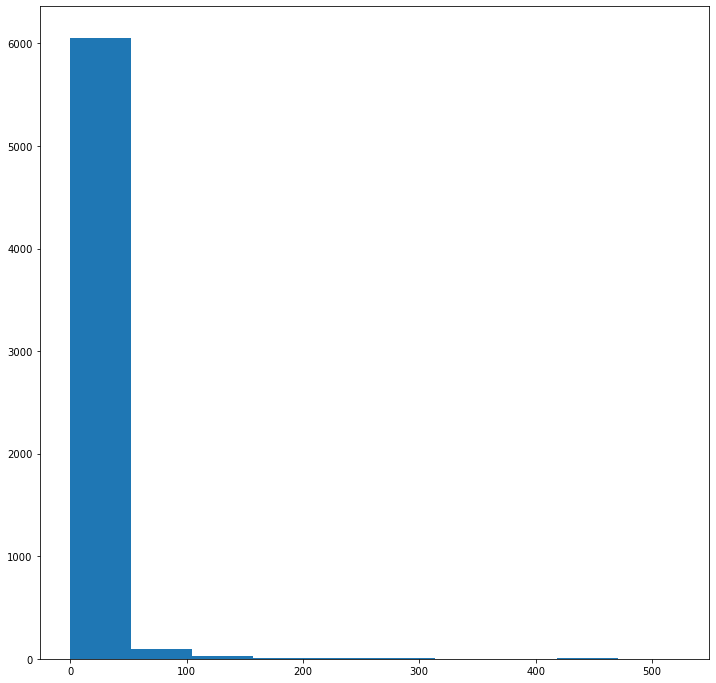

In [17]:
plotMetrics(q_jobs_submissions) 